In [15]:
import torch
import transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import count_nonzero

def calculate_sparsity(tensor):
    return 1.0 - ( count_nonzero(tensor) / float(tensor.size) )


In [2]:
base_model = transformers.AutoModel.from_pretrained("openlm-research/open_llama_3b_v2")
finetuned_model = transformers.AutoModel.from_pretrained(
    "/mnt/scratch/xiayao/cache/experiments/fmzip/finetuned_raw/llama-3b/task065_timetravel_consistent_sentence_classification/global_step102"
)

[2023-11-13 11:20:29,091] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some weights of LlamaModel were not initialized from the model checkpoint at /mnt/scratch/xiayao/cache/experiments/fmzip/finetuned_raw/llama-3b/task065_timetravel_consistent_sentence_classification/global_step102 and are newly initialized: ['model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.25.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.3.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.17.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.11.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.24.self_attn.rotary_emb.inv_freq', 'model.layers.23.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rota

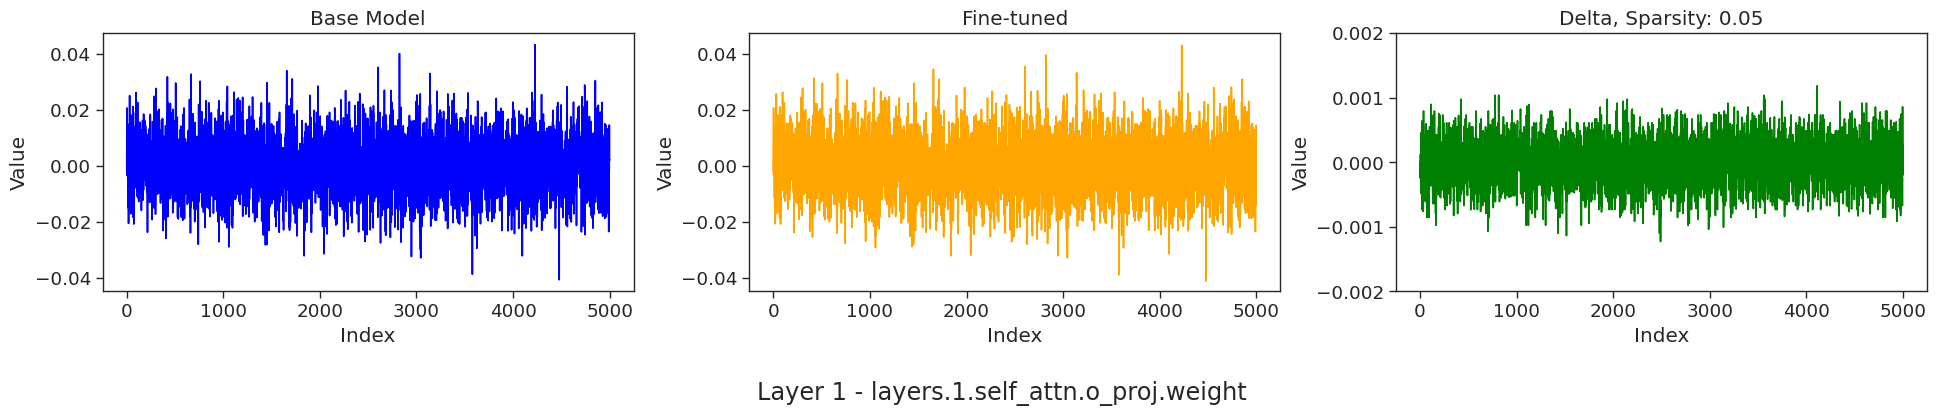

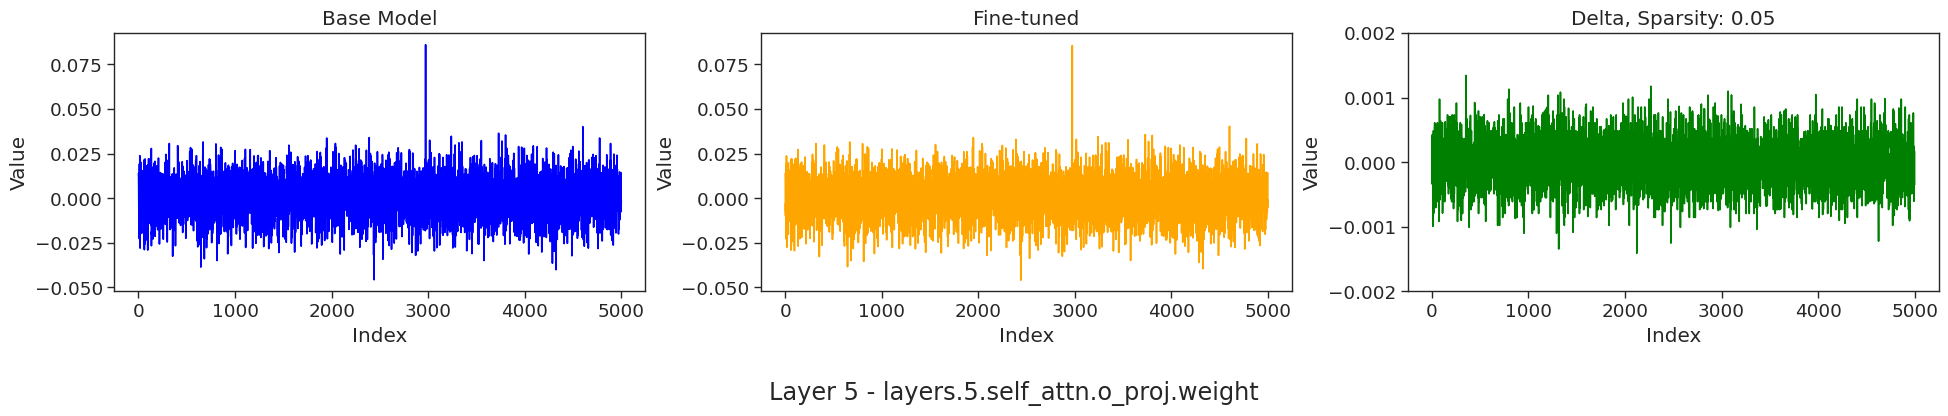

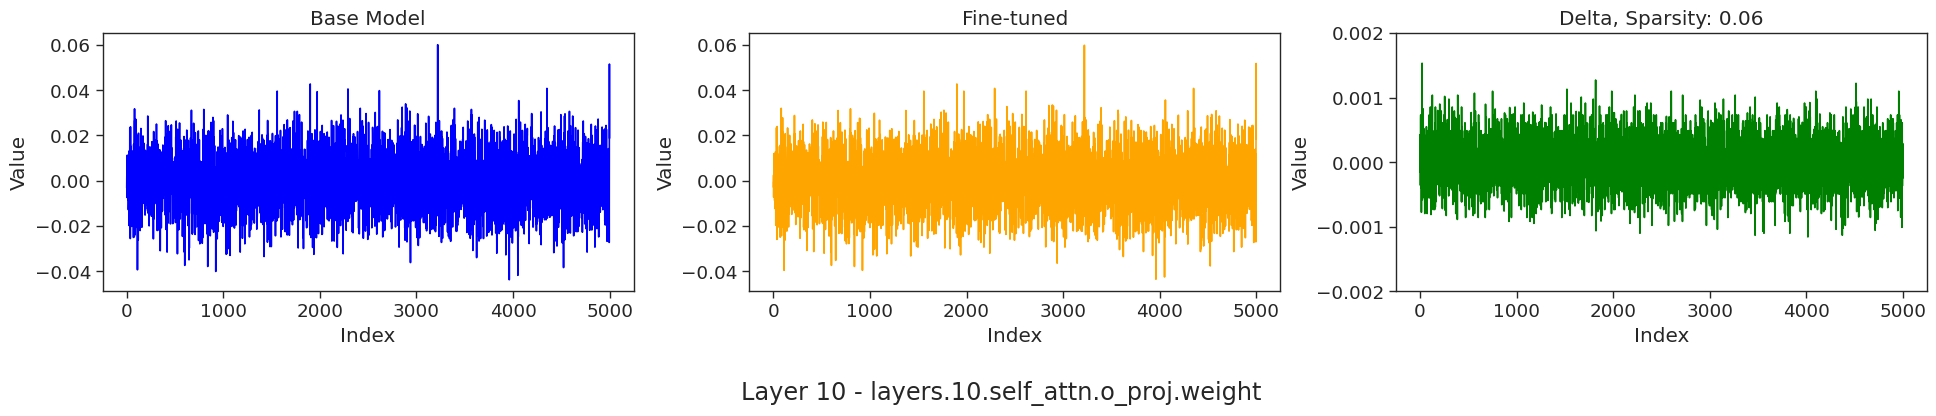

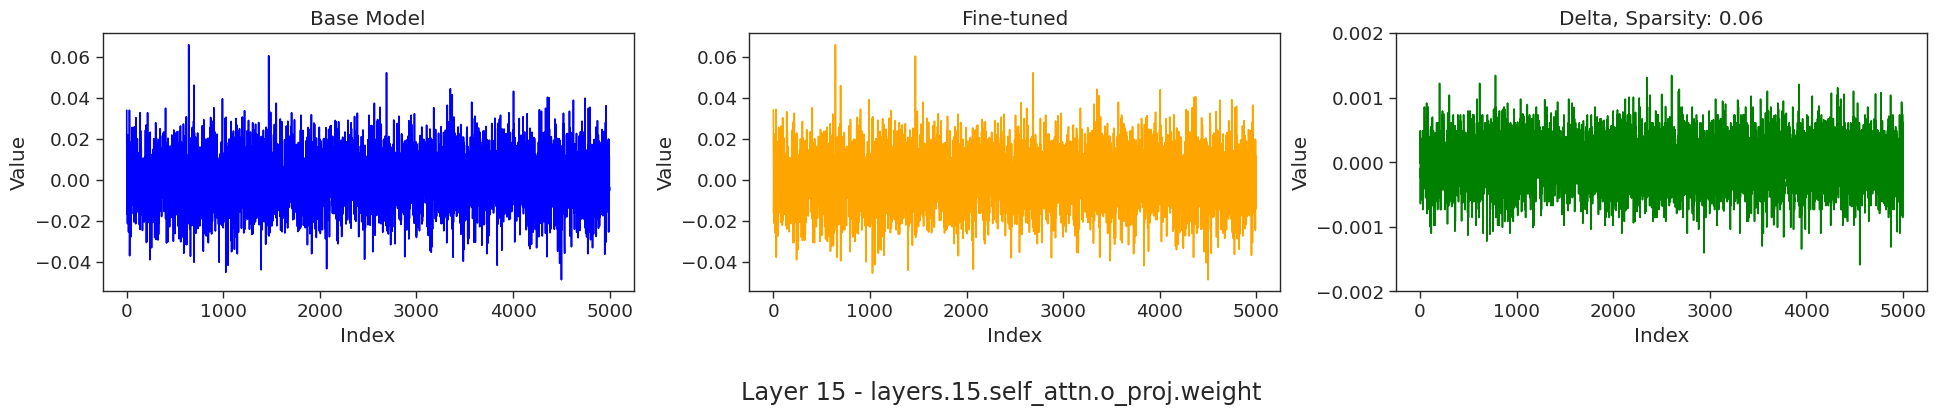

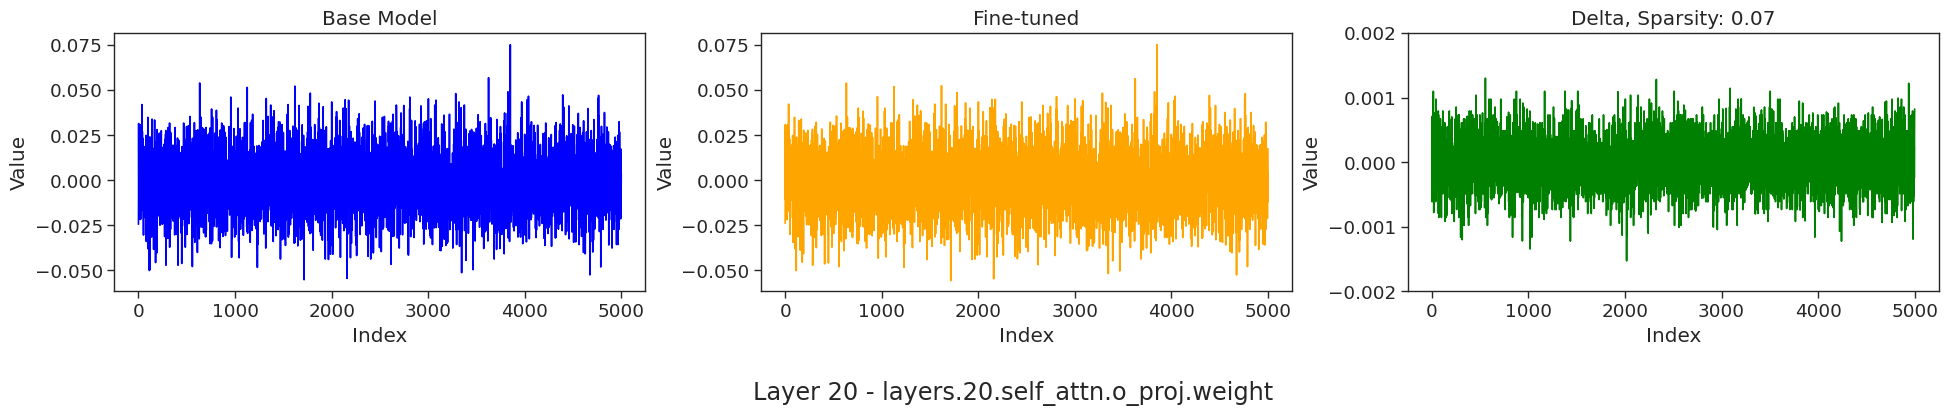

In [16]:
layers = [1, 5, 10, 15, 20]

for layer in layers:
    # print(finetuned_model.state_dict())
    focus_name = f"layers.{layer}.self_attn.o_proj.weight"
    # focus_name = f"decoder.layers.{layer}.self_attn.k_proj.weight"
    # plot distribution of weights of pretrained model and fine-tuned model
    plot_finetuned_weight = None
    plot_pretrained_weight = None
    plot_delta_weight = None

    plot_finetuned_weight = (
        finetuned_model.state_dict()[focus_name].flatten().cpu().numpy()
    )
    plot_pretrained_weight = base_model.state_dict()[focus_name].flatten().cpu().numpy()
    plot_delta_weight = plot_finetuned_weight - plot_pretrained_weight
    # report mean and std of weights
    # sample 1000 weights from the same indices
    sample_size = 5000
    sampled_indices = np.random.choice(
        len(plot_finetuned_weight), size=sample_size, replace=False
    )
    plot_finetuned_weight = plot_finetuned_weight[sampled_indices]
    plot_pretrained_weight = plot_pretrained_weight[sampled_indices]
    plot_delta_weight = plot_delta_weight[sampled_indices]
    sns.set_theme(style="whitegrid")
    sns.set(rc={"figure.figsize": (11.7, 8.27)})
    sns.set(font_scale=1.5)
    sns.set_style("ticks")
    sns.set_context("paper", font_scale=1.5)

    # make subplot
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"Layer {layer} - {focus_name}", y=0)
    fig.tight_layout(pad=3.0)
    # plot distribution of weights of pretrained model
    sns.lineplot(ax=axs[0], data=plot_pretrained_weight, color="blue")
    axs[0].set_title("Base Model")
    axs[0].set_xlabel("Index")
    axs[0].set_ylabel("Value")
    # set x limit to be the same as pretrained model

    # plot distribution of weights of fine-tuned model
    sns.lineplot(ax=axs[1], data=plot_finetuned_weight, color="orange")
    axs[1].set_title("Fine-tuned")
    axs[1].set_xlabel("Index")
    axs[1].set_ylabel("Value")
    axs[1].set_ylim(axs[0].get_ylim())
    # plot distribution of weights of fine-tuned model
    sns.lineplot(ax=axs[2], data=plot_delta_weight, color="green")
    axs[2].set_title(f"Delta, Sparsity: {calculate_sparsity(plot_delta_weight):.2f}")
    axs[2].set_xlabel("Index")
    axs[2].set_ylabel("Value")
    # axs[2].set_ylim(axs[0].get_ylim())
    axs[2].set_ylim((-0.002, 0.002))
    plt.show()